In [2]:
import os, glob
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import ImageGrid
import json
import pickle
import csv

# Collect trial info

In [3]:
# Make sure to update the followings to the correct value
units_input = 425
units_output_upper = 368
units_output_lower = 368 # linear + relu

In [4]:
dir_results = '../results'
flist       = glob.glob(f'{dir_results}/*/*/*.csv')
RESULTS={}
for k, kf in enumerate(flist): # kf = f_csv
    RESULTS[k] = {}
    RESULTS[k]['lot'] = kf.split('/')[-3]
    RESULTS[k]['trial'] = kf.split('/')[-2]
    
    # collect csv data
    # : val loss
    work = pd.read_csv(kf)['val_loss']
    if len(work)!=12:  # -4 is for non-unit hp
        # cheange for unit_11 exist...
        del RESULTS[k] 
        continue
    RESULTS[k]['val_loss'] = np.array(work)
    RESULTS[k]['min_val_loss'] = work.min()
    RESULTS[k]['min_val_loss_epoch'] = work.argmin()+1 # 0-based index
        
    # collect json data
    # : num_layers activation  batch_size optimizer units_{klayer}
    f_json  = f"../results/{RESULTS[k]['lot']}/{RESULTS[k]['trial']}/trial.json"
    with open(f_json) as f:
        work = json.load(f)
    for khp in ['activation','batch_size','num_layers','optimizer']:
        RESULTS[k][khp] = work['hyperparameters']['values'][khp]

    # check the sanity of trial.json (for unit)
    
    # if False: #len(work['hyperparameters']['values'])-4 != 12:
    if f"units_{RESULTS[k]['num_layers']-1}" not in work['hyperparameters']['values'].keys():
        # print('ERROR (%s, %s)'%(RESULTS[k]['lot'], RESULTS[k]['trial']))
        del RESULTS[k]
        continue
    else:
        units = np.array( [work['hyperparameters']['values']['units_%d'%(k)] 
                           for k in range(RESULTS[k]['num_layers'])] )
        RESULTS[k]['units'] = units
    

    # Add Num_Params
    # WORK HERE 
    # to do
    # - add lower output layer params.
    layers = np.array([units_input, *units, units_output_upper, units_output_lower])
    RESULTS[k]['num_parameters'] = np.sum((layers[:-1]+1) * layers[1:])
    
RESULTS_PD = pd.DataFrame(RESULTS).transpose()

In [5]:
# save RESULTS_PD to csv after sorting by val_loss
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))
RESULTS_PD.to_csv('step1_results_v2.csv')

7986


# Visualization (HP vs. min val loss)

top 10% (blue) and top 1% (orange) models

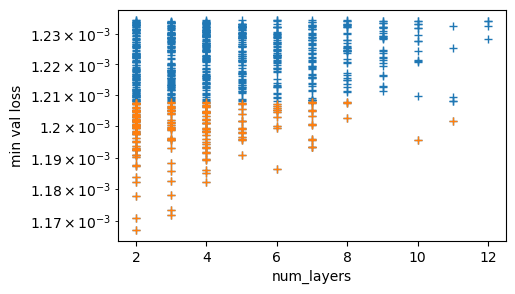

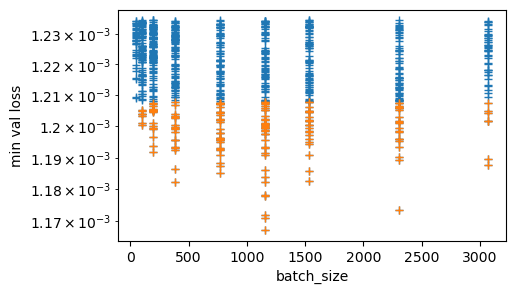

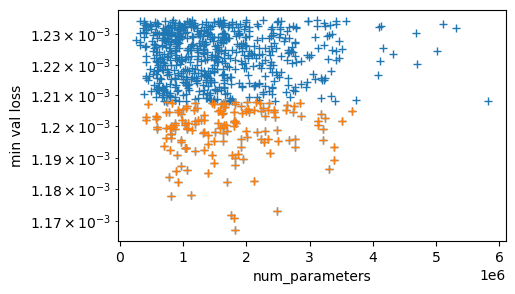

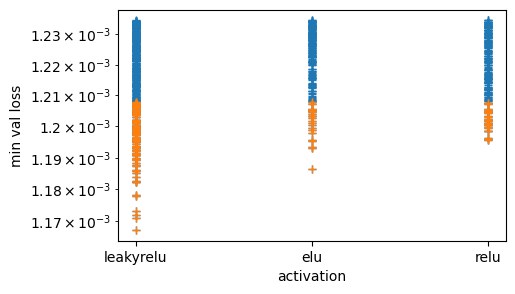

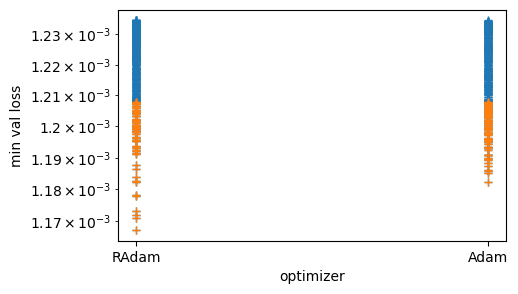

In [6]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.99))].iloc[-1] # top 99% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.10))].iloc[-1] # top 10%
th_loss_5p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.05))].iloc[-1] # top 3%
th_loss_4p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.04))].iloc[-1] # top 3%
th_loss_2p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.02))].iloc[-1] # top 3%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 1%

for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_10p, th_loss_2p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

top 99% (blue) and top 1% (orange) models

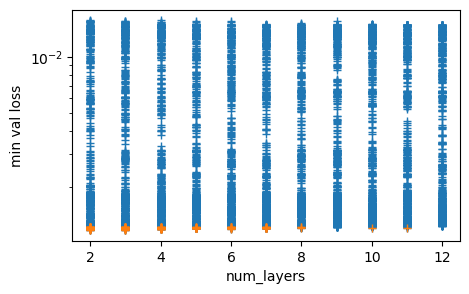

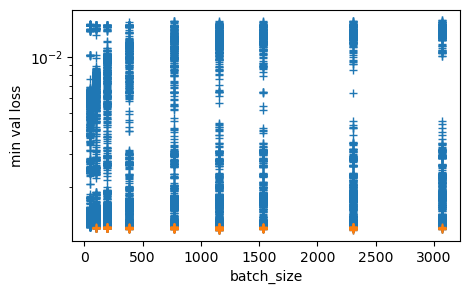

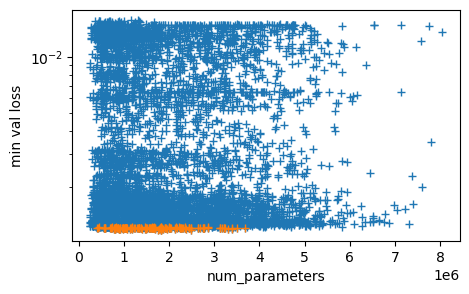

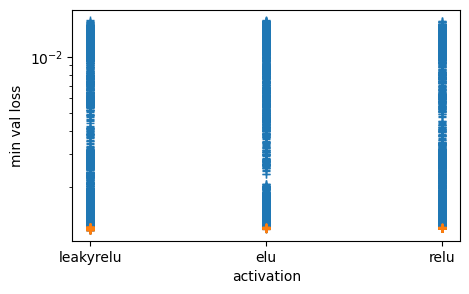

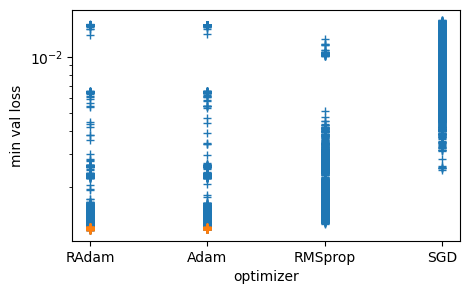

In [10]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.99))].iloc[-1] # top 99% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.10))].iloc[-1] # top 10%
th_loss_4p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.04))].iloc[-1] # top 3%
th_loss_2p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.02))].iloc[-1] # top 3%
th_loss_1p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.01))].iloc[-1] # top 1%


for kvar in ['num_layers', 'batch_size', 'num_parameters', 'activation', 'optimizer']:
    fig, ax = plt.subplots()
    for kth in [th_loss_99p, th_loss_2p]:
        ploty = RESULTS_PD['min_val_loss']
        indy = ploty<kth
        ploty = ploty[indy]
        plotx = RESULTS_PD[kvar]
        plotx = plotx[indy]
        ax.plot(plotx,ploty, ls='none', marker='+')
    ax.set_yscale('log')
    ax.set_xlabel(kvar)
    ax.set_ylabel('min val loss')
    fig.set_size_inches(5,3)

num_params vs. num_layers

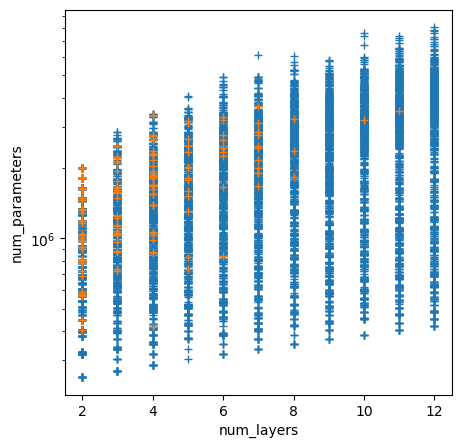

In [11]:
th_loss_99p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*.99))].iloc[-1] # top 10% 
th_loss_10p = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.1))].iloc[-1] # top 10%
th_loss_2p  = RESULTS_PD['min_val_loss'][:int(np.ceil(len(RESULTS_PD)*0.02))].iloc[-1] # top 10%

kvar_y='num_parameters'
kvar_x='num_layers'
fig, ax = plt.subplots()
for kth in [th_loss_99p, th_loss_2p]:
    ploty = RESULTS_PD['min_val_loss']
    indy = ploty<kth
    ploty = RESULTS_PD[kvar_y]
    ploty = ploty[indy]
    plotx = RESULTS_PD[kvar_x]
    plotx = plotx[indy]
    ax.plot(plotx,ploty, ls='none', marker='+')
ax.set_yscale('log')
ax.set_xlabel(kvar_x)
ax.set_ylabel(kvar_y)
fig.set_size_inches(5,5)



# Pick the best models

In [12]:
RESULTS_PD = pd.DataFrame(RESULTS).transpose()
RESULTS_PD.sort_values('min_val_loss', inplace=True)
print(len(RESULTS_PD))
print(len(RESULTS_PD)*0.02)

7986
159.72


In [14]:
TOP160 = RESULTS_PD.iloc[:160]
with open('top160.lot.v2.txt', 'w') as f:
    f.writelines([ k+'\n' for k in TOP160['lot'].values ])
with open('top160.trial.v2.txt', 'w') as f:
    f.writelines([ k+'\n' for k in TOP160['trial'].values ])
TOP160

,lot,trial,val_loss,min_val_loss,min_val_loss_epoch,activation,batch_size,num_layers,optimizer,units,num_parameters
3976,lot-89,trial_0025,"[0.0015076427953317, 0.0013557822676375, 0.001...",0.001167,12,leakyrelu,1152,2,RAdam,"[1024, 896]",1820512
8404,lot-146,trial_0046,"[0.0014490471221506, 0.0013775214320048, 0.001...",0.001171,12,leakyrelu,1152,2,RAdam,"[896, 1024]",1813216
3660,lot-147,trial_0030,"[0.0014384662499651, 0.0013361682649701, 0.001...",0.001172,12,leakyrelu,1152,3,RAdam,"[384, 768, 1024]",1759712
9966,lot-150,trial_0043,"[0.0015413402579724, 0.0013640598626807, 0.001...",0.001173,12,leakyrelu,2304,3,RAdam,"[640, 1024, 1024]",2491616
3034,lot-112,trial_0042,"[0.0015212742146104, 0.0013826673384755, 0.001...",0.001178,12,leakyrelu,1152,2,RAdam,"[256, 896]",805216
...,...,...,...,...,...,...,...,...,...,...,...
2388,lot-178,trial_0016,"[0.0013086753897368, 0.0012714799959212, 0.001...",0.001208,12,leakyrelu,384,4,RAdam,"[1024, 1024, 128, 128]",1816800
4850,lot-116,trial_0045,"[0.0015750469174236, 0.0014743817737326, 0.001...",0.001208,11,elu,1536,7,Adam,"[128, 768, 256, 768, 768, 768, 256]",2156256
8244,lot-53,trial_0032,"[0.001569538610056, 0.0013439455069601, 0.0014...",0.001208,12,elu,1152,7,RAdam,"[512, 896, 640, 256, 256, 384, 384]",2005728
11568,lot-94,trial_0014,"[0.0014380461070686, 0.0012877820990979, 0.001...",0.001208,12,leakyrelu,1536,3,Adam,"[384, 768, 128]",740960
